# Automaticly Diagnosis of NAFLD

In [1]:
# importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
import sys
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice
from sklearn.preprocessing import MultiLabelBinarizer

# Scores
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

### Useful Functions:

- find_val_score function calculates the f1 score using cross_val_score function in sklearn
- find_best function finds the best parameters for estimator on data-set
- find_roccurve function calculates the auc score and tpr, fpr values.
- calculate_scores function, calculates the MAE, MSE and R2 scores for Regressors.
- plot_error_scores plots the error scores of models based on different approaches

In [2]:
def find_val_score(classifier, X, y):
    scores = cross_val_score(estimator=classifier,
                         X=X,
                         y=y,
                         cv=10,
                         scoring='f1')
    return (scores.mean(), scores.std())

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
def find_best(classifier, X_train, y_train, param_grid):
    gs = GridSearchCV(estimator=classifier, 
                      param_grid=param_grid, 
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

# Finding roc_curve and Auc score for each classifier
def find_roccurve(classifier,X_train,X_test,y_train,y_test):
    classifier.fit(X_train, y_train)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    # print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    return (auc, fpr, tpr, thresholds)

In [3]:
def return_f1_scores(X, y, X_train, y_train):
    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(random_state=0, n_jobs=-1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True)]])
    pipe_knn = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_jobs=-1)]])
    pipe_dt = Pipeline([['sc', StandardScaler()], ['clf', DecisionTreeClassifier(random_state=0)]])

    lr_grid = [{'clf__C': param_range,
                'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    knn_grid = [{'clf__n_neighbors': [5, 10, 30, 50]}]
    
    dt_grid = [{'clf__max_depth': [None, 1, 2, 3]}]

    lr_params = find_best(pipe_lr, X_train, y_train, lr_grid)
    svm_params = find_best(pipe_svm, X_train, y_train, svm_grid)
    knn_params = find_best(pipe_knn, X_train, y_train, knn_grid)
    dt_params = find_best(pipe_dt, X_train, y_train, dt_grid)

    lr_score = find_val_score(lr_params[2], X, y)
    svm_score = find_val_score(svm_params[2], X, y)
    knn_score = find_val_score(knn_params[2], X, y)
    dt_score = find_val_score(dt_params[2], X, y)

    return (lr_score, svm_score, knn_score, dt_score)

In [4]:
def calculate_error_scores(X_train, X_test, y_train, y_test, regressor):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mae_score = mean_absolute_error(y_test, y_pred)
    mse_score = mean_squared_error(y_test, y_pred)
    r2_score_ = r2_score(y_test, y_pred)
    return (mae_score, mse_score, r2_score_)

In [5]:
def plot_error_scores(num, title, save=False):
    scores = baseline_error_scores[num]['score']
    name = baseline_error_scores[num]['name']
    scores = {'lr':[scores['lr'][0], scores['lr'][1], scores['lr'][2]],
             'svr':[scores['svr'][0], scores['svr'][1], scores['svr'][2]],
             'knn':[scores['knn'][0], scores['knn'][1], scores['knn'][2]],
             'dt':[scores['dt'][0], scores['dt'][1], scores['dt'][2]]}
    
    class_names = {'lr': 'LinearRegression', 'svr': 'SupportVector Regressor',
                   'knn':'KNN Regressor', 'dt':'DecisionTree Regressor'}

    scores_names = ['MAE', 'MSE', 'R2']

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
    ax = np.ravel(ax)
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    for idx, mthod in zip([i for i in range(4)], scores.keys()):
        ax[idx].bar(scores_names, [round(i,3) for i in scores[mthod]], 
                               align='center', alpha=1.0, color=clr)
        ax[idx].set_yticks([a for a in range(0,4)])
        legends = []
        for c in range(len(scores_names)):
            legends.append(mpatches.Patch(color=clr[c], label='{}: {}'.format(scores_names[c], 
                                                                              round(scores[mthod][c],3))))
        ax[idx].legend(handles=legends,loc='best')
        ax[idx].set_xlabel('Error Algorithms')
        ax[idx].set_ylabel("Error Algorithms' Scores")
        ax[idx].title.set_text('MAE, MSE & R2 Scores By {}'.format(class_names[mthod]))
    fig.suptitle('Error Scores of {} For \"{}\" column'.format(title, name),y=1.02, fontsize=16)
    fig.tight_layout()
    if save:
        fig.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

## Importing Data & Data Pre-Processing

In [6]:
data = pd.read_excel("NAFLD_en.xlsx")
features_df = data.iloc[:,1:-9]
targets_df = data.iloc[:,-9:]

In [7]:
for clm in targets_df.columns[-2:]:
    targets_df[clm] = targets_df[clm].map({1:0, 2:1})

In [8]:
missing_val_counts = {}
for col in features_df.columns:
    missing_val_counts[col] = features_df[col].isnull().sum()

In [9]:
baseline_features = []
for col, value in missing_val_counts.items():
    if value == 0:
        baseline_features.append(col)
baseline_features = features_df[baseline_features]

### Baseline Model F1-Scores

In [10]:
# F1-Scores For Each Target
baseline_f1_scores = {}
for num, name in enumerate(targets_df.columns[2:]):
    target = targets_df[name].values
    X_train, X_test, y_train, y_test = train_test_split(baseline_features.values, target,
                                                                    test_size = 0.3, random_state = 0)
    
    f1_scores = return_f1_scores(baseline_features.values, target, X_train, y_train)
    baseline_f1_scores[num] = {'name':name, 'score':f1_scores}

In [11]:
def plot_baseline_f1_scores(num, save=False):
    scores = baseline_f1_scores[num]['score']
    name = baseline_f1_scores[num]['name']

    scores = {'score':[scores[0], scores[1], scores[2], scores[3]]}

    class_names = {'score':'Baseline Approach F1-Scores'}

    classifier_names = ['LR', 'SVM', 'KNN', 'DT']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    for idx, mthod in zip([i for i in range(1)], scores.keys()):
        ax.bar(classifier_names, [round(i[0]*100,2) for i in scores[mthod]], 
                               align='center', alpha=1.0, color=clr)
        ax.set_yticks([i for i in range(0,110,10)])
        legends = []
        for i in range(len(classifier_names)):
            legends.append(mpatches.Patch(color=clr[i], label='{}: {}'.format(classifier_names[i], 
                                                                              round(scores[mthod][i][0]*100,2))))
        ax.legend(handles=legends,loc='best')
        ax.set_xlabel('Classifiers')
        ax.set_ylabel('F1 Scores')
        ax.title.set_text(class_names[mthod])
    # fig.tight_layout()
    fig.suptitle('Baseline Approach (17 features) F1-Scores on\n\"{}\" column'.format(name),
                 y=1.03, fontsize=14)
    if save:
        # 'f1_scores_knn_mice'
        fig.savefig(save, dpi=300, bbox_inches='tight')

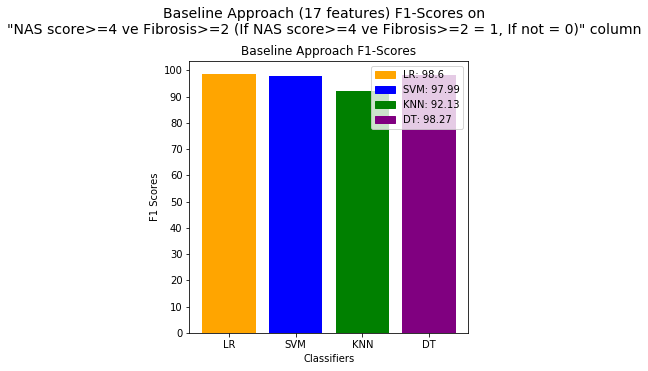

In [12]:
plot_baseline_f1_scores(0, save="f1_scores_baseline_0")

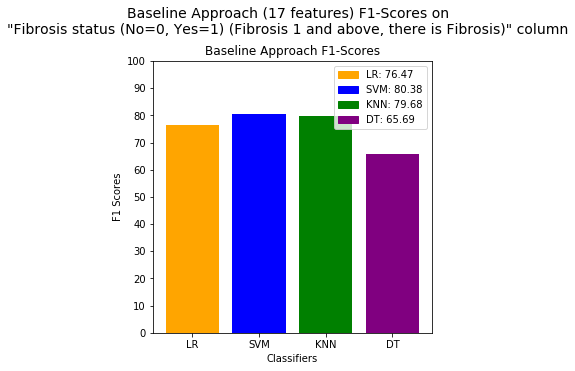

In [13]:
plot_baseline_f1_scores(1, save="f1_scores_baseline_1")

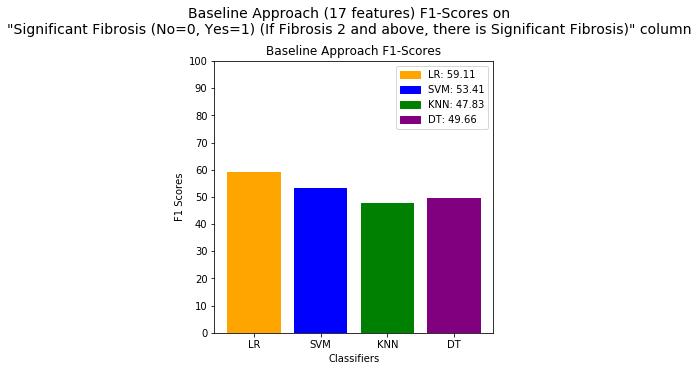

In [14]:
plot_baseline_f1_scores(2, save="f1_scores_baseline_2")

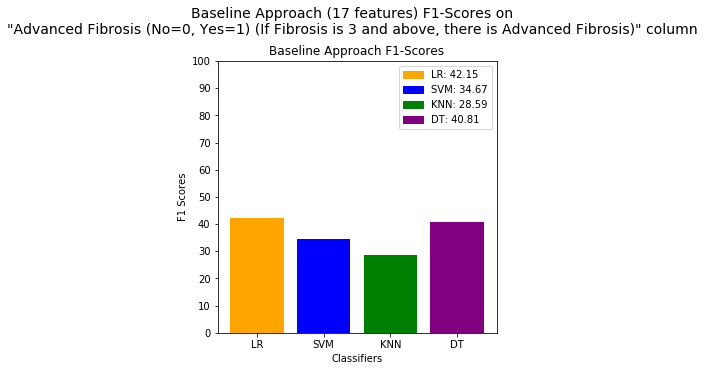

In [15]:
plot_baseline_f1_scores(3, save="f1_scores_baseline_3")

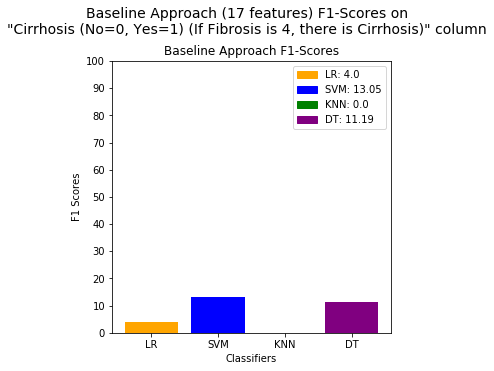

In [16]:
plot_baseline_f1_scores(4, save="f1_scores_baseline_4")

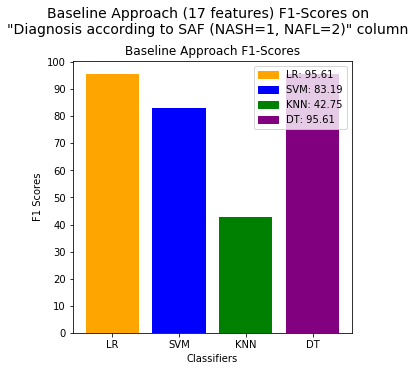

In [17]:
plot_baseline_f1_scores(5, save="f1_scores_baseline_5")

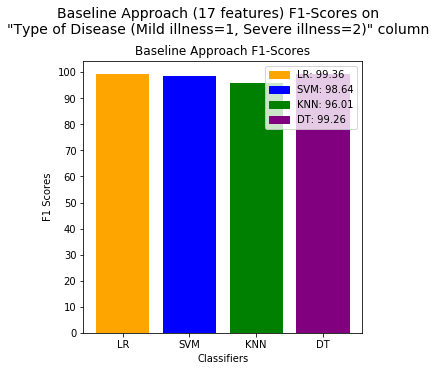

In [18]:
plot_baseline_f1_scores(6, save="f1_scores_baseline_6")

### Baseline Model Error Scores

In [19]:
pipe_lr_reg = Pipeline([['sc', StandardScaler()], ['clf', LinearRegression(n_jobs=-1)]])
pipe_svr_reg = Pipeline([['sc', StandardScaler()], ['clf', SVR()]])
pipe_knn_reg = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsRegressor(n_jobs=-1)]])
pipe_dt_reg = Pipeline([['sc', StandardScaler()], ['clf', DecisionTreeRegressor(random_state=0)]])

In [20]:
# Error Scores For BB & BC Target
baseline_error_scores = {}
for num, name in enumerate(targets_df.columns[:2]):
    target = targets_df[name].values
    X_train, X_test, y_train, y_test = train_test_split(baseline_features.values, target,
                                                                    test_size = 0.3, random_state = 0)
    
    lr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_lr_reg)
    svr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_svr_reg)
    knn_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_knn_reg)
    dt_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_dt_reg)
    baseline_error_scores[num] = {'name':name, 'score':{'lr':lr_errors, 'svr':svr_errors, 'knn':knn_errors, 'dt':dt_errors}}

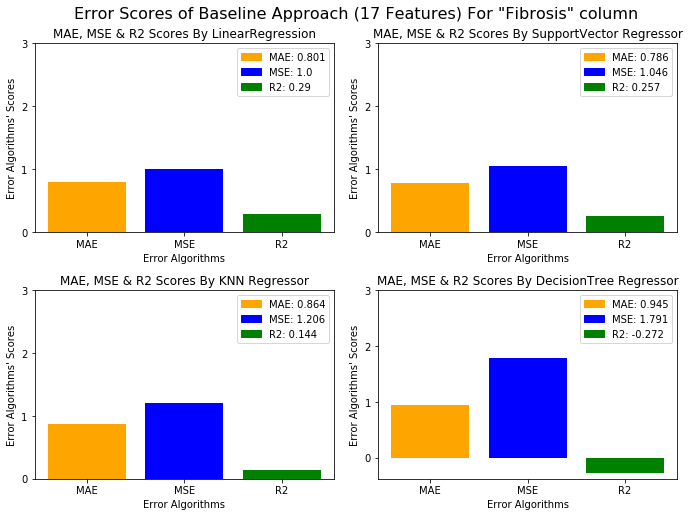

In [21]:
plot_error_scores(0,'Baseline Approach (17 Features)', save='error_baseline_bb')

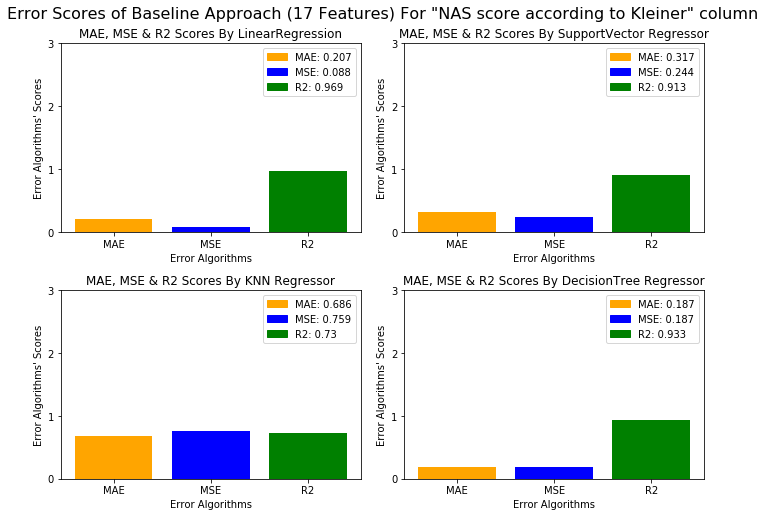

In [22]:
plot_error_scores(1, 'Baseline Approach (17 Features)', save='error_baseline_bc')

### KNN & MICE Imputations' F1 Scores to define which imputation techniques we should use

In [23]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
features_knn = fast_knn(features_df.values, k=30)
features_mice = mice(features_df.values)

In [24]:
# F1-Scores For Each Target
targets_f1_scores = {}
for num, name in enumerate(targets_df.columns[2:]):
    target = targets_df[name].values
    X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(features_knn, target,
                                                                    test_size = 0.3, random_state = 0)
    X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(features_mice, target,
                                                                    test_size = 0.3, random_state = 0)
    
    knn_f1_scores = return_f1_scores(features_knn, target, X_train_knn, y_train_knn)
    mice_f1_scores = return_f1_scores(features_mice, target, X_train_mice, y_train_mice)
    targets_f1_scores[num] = {'name':name, 'knn':knn_f1_scores, 'mice':mice_f1_scores}

In [25]:
def plot_imputation_f1_scores(num, save=False):
    knn_scores = targets_f1_scores[num]['knn']
    mice_scores = targets_f1_scores[num]['mice']
    name = targets_f1_scores[num]['name']

    scores = {'knn':[knn_scores[0], knn_scores[1], knn_scores[2], knn_scores[3]],
              'mice':[mice_scores[0],mice_scores[1],mice_scores[2], mice_scores[3]]}

    class_names = {'knn':'KNN-Based Imputation F1-Scores',
                   'mice':'MICE Imputation F1-Scores'}

    classifier_names = ['LR', 'SVM', 'KNN', 'DT']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    for idx, mthod in zip([i for i in range(2)], scores.keys()):
        ax[idx].bar(classifier_names, [round(i[0]*100,2) for i in scores[mthod]], 
                               align='center', alpha=1.0, color=clr)
        ax[idx].set_yticks([i for i in range(0,110,10)])
        legends = []
        for i in range(len(classifier_names)):
            legends.append(mpatches.Patch(color=clr[i], label='{}: {}'.format(classifier_names[i], 
                                                                              round(scores[mthod][i][0]*100,2))))
        ax[idx].legend(handles=legends,loc='best')
        ax[idx].set_xlabel('Classifiers')
        ax[idx].set_ylabel('F1 Scores')
        ax[idx].title.set_text(class_names[mthod])
    # fig.tight_layout()
    fig.suptitle('KNN & MICE Imputation F1-Scores on\n\"{}\" column'.format(name),
                 y=1.03, fontsize=16)
    if save:
        # 'f1_scores_knn_mice'
        fig.savefig(save, dpi=300, bbox_inches='tight')

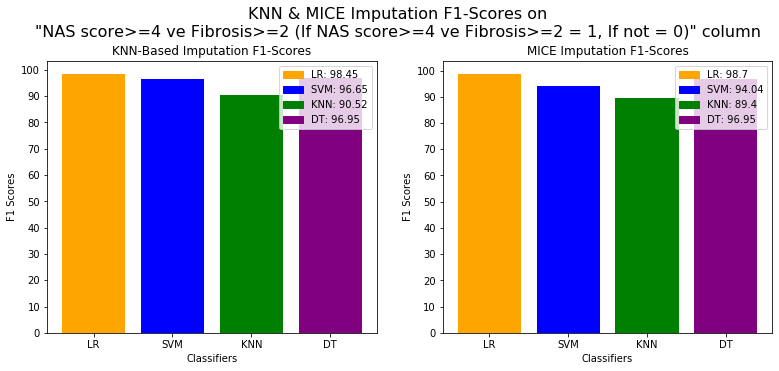

In [26]:
plot_imputation_f1_scores(0, save="f1_scores_knn_mice_0")

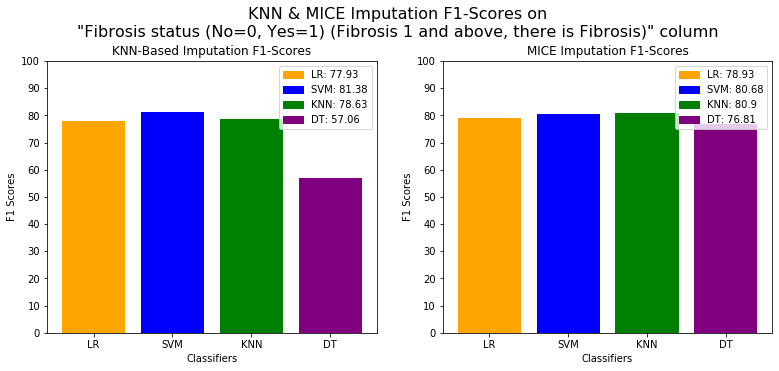

In [27]:
plot_imputation_f1_scores(1, save="f1_scores_knn_mice_1")

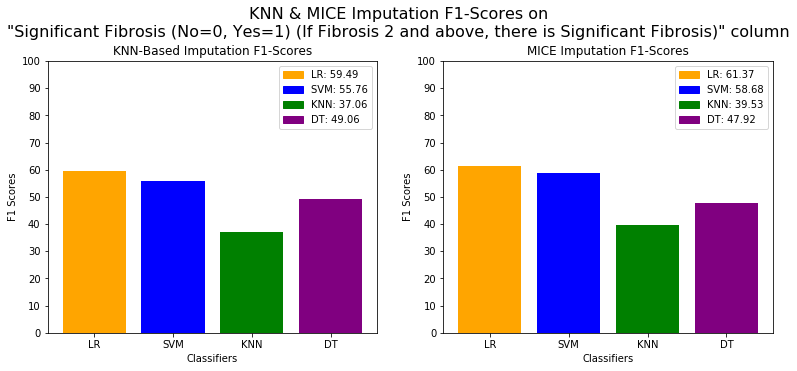

In [28]:
plot_imputation_f1_scores(2, save="f1_scores_knn_mice_2")

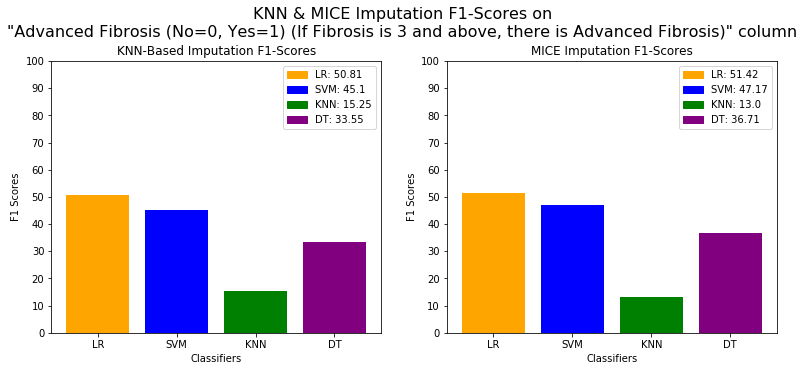

In [29]:
plot_imputation_f1_scores(3, save="f1_scores_knn_mice_3")

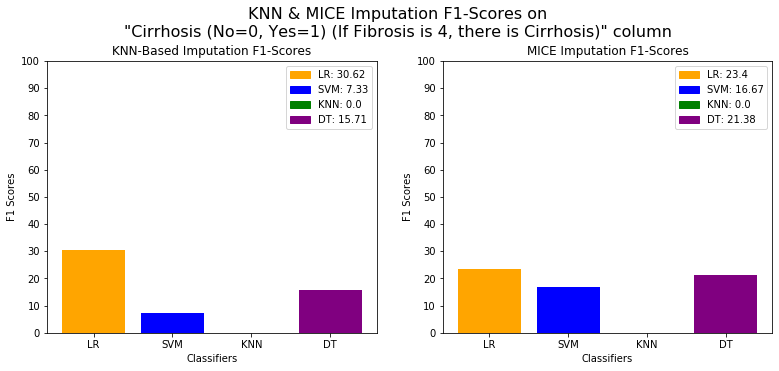

In [30]:
plot_imputation_f1_scores(4, save="f1_scores_knn_mice_4")

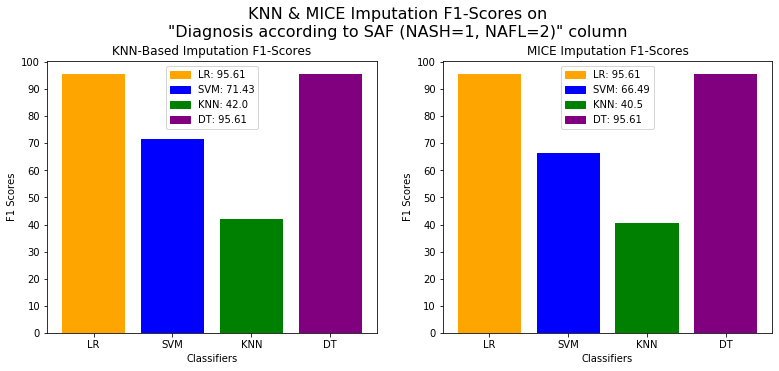

In [31]:
plot_imputation_f1_scores(5, save="f1_scores_knn_mice_5")

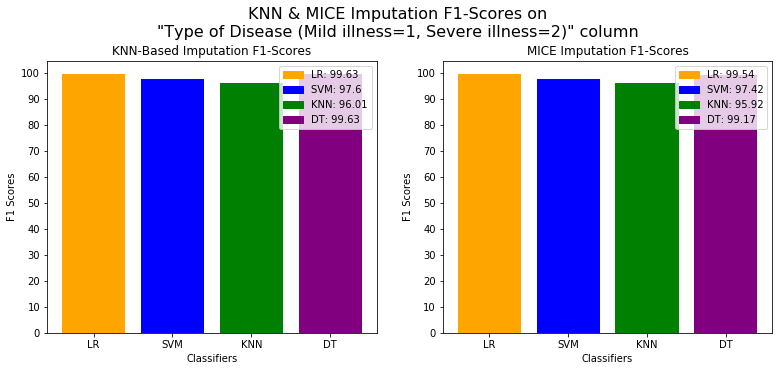

In [32]:
plot_imputation_f1_scores(6, save="f1_scores_knn_mice_6")

### MICE Error Scores on 52 Features

In [33]:
# Error Scores For BB & BC Target With MICE Imputation
mice_error_scores = {}
for num, name in enumerate(targets_df.columns[:2]):
    target = targets_df[name].values
    X_train, X_test, y_train, y_test = train_test_split(features_mice, target,
                                                                    test_size = 0.3, random_state = 0)
    
    lr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_lr_reg)
    svr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_svr_reg)
    knn_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_knn_reg)
    dt_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_dt_reg)
    baseline_error_scores[num] = {'name':name, 'score':{'lr':lr_errors, 'svr':svr_errors, 'knn':knn_errors, 'dt':dt_errors}}

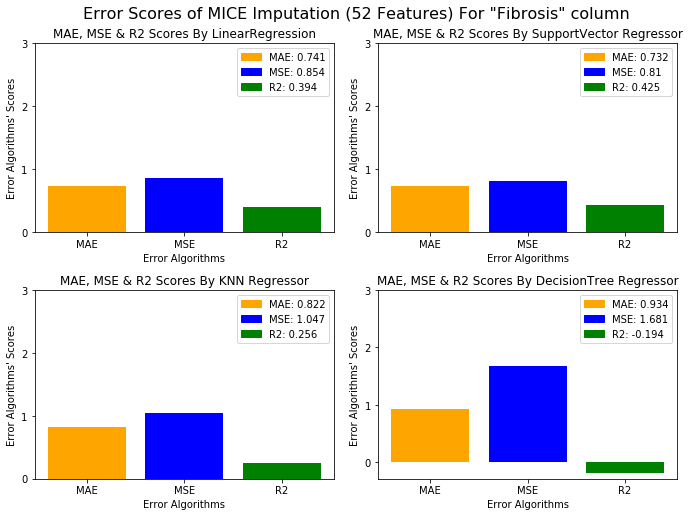

In [34]:
plot_error_scores(0, 'MICE Imputation (52 Features)', save='error_mice_bb')

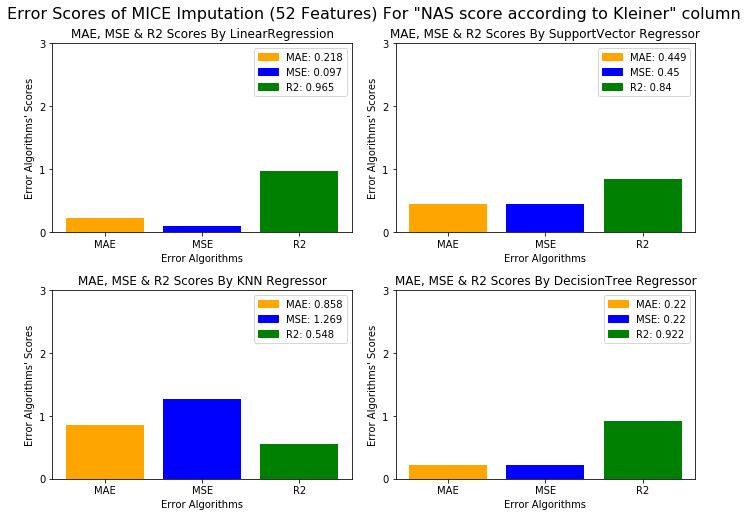

In [35]:
plot_error_scores(1, 'MICE Imputation (52 Features)', save='error_mice_bc')